In [1]:
import random
import os
import pandas as pd 
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision.transforms as tf
from PIL import Image
import numpy as np
import timm
from sklearn.metrics import mean_squared_error
import wandb

# Setting seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

# Read data
df = pd.read_excel('/home/user/Desktop/aman/data/image_external_dataset/external_training_set_pixel_size_and_HC_image_path_filtered.xlsx')



trainval, test = train_test_split(df['filename'].unique(), test_size=0.1, random_state=SEED)
train, valid = train_test_split(trainval, test_size=0.11, shuffle=True, random_state=SEED)
train_df = df[df['filename'].isin(train)].reset_index(drop=True)
valid_df = df[df['filename'].isin(valid)].reset_index(drop=True)
test_df = df[df['filename'].isin(test)].reset_index(drop=True)

# Function to calculate mean and standard deviation
def calculate_stats(folder_path):
    channel_sum = np.zeros((1,))  # Updated for single-channel images
    channel_sum_squared = np.zeros((1,))  # Updated for single-channel images
    num_pixels = 0

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with Image.open(file_path) as img:
            img = img.convert('L')  # Convert to grayscale
            img_array = np.array(img) / 255.0

            num_pixels += img_array.shape[0] * img_array.shape[1]
            channel_sum += img_array.sum()
            channel_sum_squared += (img_array ** 2).sum()

    mean = channel_sum / num_pixels
    std = np.sqrt((channel_sum_squared / num_pixels) - (mean ** 2))

    return mean, std

# Calculate mean and standard deviation
# Calculate mean and standard deviation
folder_path = '/home/user/Desktop/aman/data/image_external_dataset/clean_training_set'
mean, std = calculate_stats(folder_path)
print("Mean:", mean)
print("Standard Deviation:", std)

# Convert mean and std to numpy arrays
mean = np.array([mean])
std = np.array([std])

data_transform = tf.Compose([
    tf.Resize((512, 512)),
    tf.ToTensor(),
    tf.Normalize(mean=mean, std=std)
])


# Custom PyTorch Dataset
class SegData(Dataset):
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    
    def __getitem__(self, i):
        image = Image.open(self.df.loc[i]['Image_Path'])
        reg = self.df.loc[i]['HC_cm']
        if self.tfms:
            image = self.tfms(image)
        return image, torch.FloatTensor([reg])
    
    def __len__(self):
        return self.df.shape[0]

# Create datasets and dataloaders
train_dataset = SegData(train_df, data_transform)
valid_dataset = SegData(valid_df, data_transform)
test_dataset = SegData(test_df, data_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

# PyTorch Lightning Data Module
class DLS(pl.LightningDataModule):
    def __init__(self, train_loader, valid_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        
    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.valid_loader
    
    def test_dataloader(self):
        return self.test_loader

# PyTorch Lightning Model
class MaskReg_Model(pl.LightningModule):
    def __init__(self, lr):
        super().__init__()
        # Load pre-trained ResNet34 model
        self.model = timm.models.resnet34(pretrained=True)
        
        # Modify the first convolutional layer to accept single-channel images
        in_channels = 1  # For grayscale images
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Change the number of output units in the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 1)
        
        self.lr = lr
        
    def forward(self, x):
        return self.model(x)
    

    
    def shared_step(self, batch):
        x, y = batch
        y = y.float()
        x = x.float()
        preds = self.model(x)
        loss = nn.MSELoss()(preds, y)
        rmse = torch.sqrt(loss)  # Calculate RMSE from MSE
        return loss, preds, rmse
    
    def training_step(self, batch, batch_idx):
        loss, _, rmse = self.shared_step(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_rmse', rmse, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, preds, rmse = self.shared_step(batch)
        self.log('valid_loss', loss, on_epoch=True, prog_bar=True)
        self.log('valid_rmse', rmse, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, preds, rmse = self.shared_step(batch)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_rmse', rmse, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1),
            'monitor': 'valid_rmse'
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
    
    # Add a method to return hyperparameters
    def get_hyper_parameters(self):
        return {'lr': self.lr}

    # During training, save hyperparameters along with the checkpoint
    def on_save_checkpoint(self, checkpoint):
        checkpoint['hyper_parameters'] = self.get_hyper_parameters()


# Instantiate datasets
data = DLS(train_loader, valid_loader, test_loader)

# Instantiate Lightning Model
model = MaskReg_Model(lr=1e-03)

# Initialize wandb logger
wand_logger = WandbLogger(project='new_online_HC_ESTIMATION', log_model=True, name='RESNET34')

# Define Model Checkpoint Callback
checkpoint_callback = ModelCheckpoint(
    dirpath='/home/user/Desktop/aman/imaging_venv/codes/',
    monitor='valid_rmse',
    mode='min',
    filename='new_online_HC_ESTIMATION_{epoch}_{valid_rmse:.4f}_{train_rmse:.4f}_lr=sugg_RESNET.pkl',
    save_last=True,  # save the last checkpoint
    save_top_k=1,
)

# Define Lightning Trainer
trainer = pl.Trainer(
    gpus=2,
    max_epochs=200,
    logger=wand_logger,
    strategy='dp',
    callbacks=[checkpoint_callback]
)

# Train the model
trainer.fit(model, data)

# After training, load the best model along with the learning rate
best_model_path = checkpoint_callback.best_model_path
best_model = MaskReg_Model.load_from_checkpoint(best_model_path)

# Retrieve the learning rate used during training
lr_used = best_model.lr
print("Learning Rate Used:", lr_used)

# Get metrics from the best-fit checkpoint
best_model.eval()
test_results = trainer.test(best_model, test_dataloaders=data.test_dataloader())
print("Metrics of Best-fit Checkpoint:")
print("Test Loss:", test_results[0]['test_loss'])
print("Test RMSE:", test_results[0]['test_rmse'])

/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
2024-04-12 11:06:17.894899: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 11:06:18.104541: I tensor

Mean: [0.15623446]
Standard Deviation: [0.17396214]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 21.3 M
---------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.116    Total estimated model params size (MB)
/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/user/Desktop/aman/imaging_venv/codes/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

wandb: Currently logged in as: amanadapt (team-adapt). Use `wandb login --relogin` to force relogin


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Learning Rate Used: 0.001


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 4.7728095054626465, 'test_rmse': 1.9279345273971558}
--------------------------------------------------------------------------------
Metrics of Best-fit Checkpoint:
Test Loss: 4.7728095054626465
Test RMSE: 1.9279345273971558


In [2]:
torch.save(best_model.model, 'online_best_model_tep_200.pkl')

# Retrieve the learning rate used during training
lr_used = best_model.lr
print("Learning Rate Used:", lr_used)

# Get metrics from the best-fit checkpoint
best_model.eval()
test_results = trainer.test(best_model, test_dataloaders=data.test_dataloader())
print("Metrics of Best-fit Checkpoint:")
print("Test Loss:", test_results[0]['test_loss'])
print("Test RMSE:", test_results[0]['test_rmse'])

/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Learning Rate Used: 0.001


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 4.7728095054626465, 'test_rmse': 1.9279345273971558}
--------------------------------------------------------------------------------
Metrics of Best-fit Checkpoint:
Test Loss: 4.7728095054626465
Test RMSE: 1.9279345273971558


/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [8]:
import random
import os
import pandas as pd 
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision.transforms as tf
from PIL import Image
import numpy as np
import timm
from sklearn.metrics import mean_squared_error
import wandb

# Setting seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

# Read data
df = pd.read_excel('/home/user/Desktop/aman/data/image_external_dataset/external_training_set_pixel_size_and_HC_image_path_filtered.xlsx')



trainval, test = train_test_split(df['filename'].unique(), test_size=0.1, random_state=SEED)
train, valid = train_test_split(trainval, test_size=0.11, shuffle=True, random_state=SEED)
train_df = df[df['filename'].isin(train)].reset_index(drop=True)
valid_df = df[df['filename'].isin(valid)].reset_index(drop=True)
test_df = df[df['filename'].isin(test)].reset_index(drop=True)


/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
2024-04-16 15:20:54.743865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 15:20:54.911405: I tensor

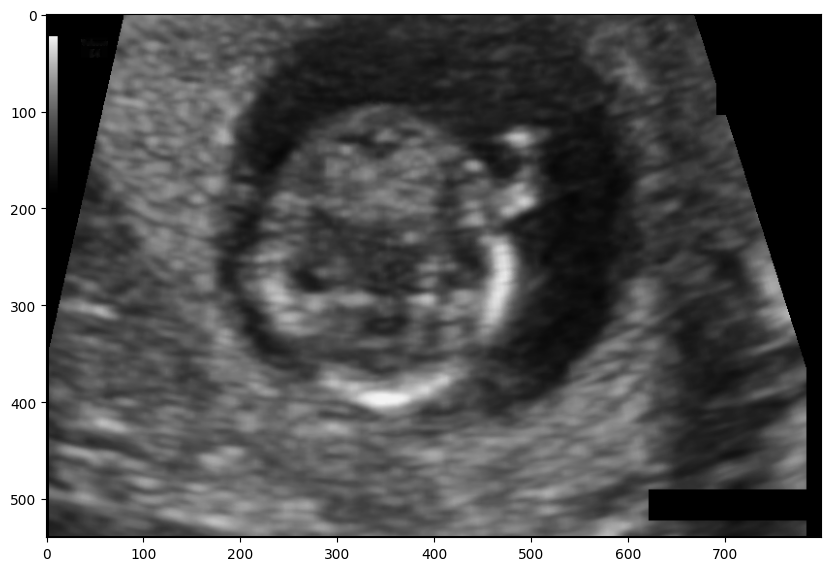

In [11]:
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread(df.loc[10]['Image_Path']))

In [12]:
import pandas as pd

df = pd.read_excel('/home/user/Desktop/aman/data/image_external_dataset/external_training_set_pixel_size_and_HC_image_path_filtered.xlsx')

In [13]:
df

,filename,pixel size(mm),head circumference (mm),HC_cm,Image_Path
0,000_HC.png,0.069136,44.30,4.430,/home/user/Desktop/aman/data/image_external_da...
1,001_HC.png,0.089659,56.81,5.681,/home/user/Desktop/aman/data/image_external_da...
2,002_HC.png,0.062033,68.75,6.875,/home/user/Desktop/aman/data/image_external_da...
3,003_HC.png,0.091291,69.00,6.900,/home/user/Desktop/aman/data/image_external_da...
4,004_HC.png,0.061240,59.81,5.981,/home/user/Desktop/aman/data/image_external_da...
...,...,...,...,...,...
801,801_HC.png,0.296851,329.26,32.926,/home/user/Desktop/aman/data/image_external_da...
802,802_HC.png,0.212267,330.90,33.090,/home/user/Desktop/aman/data/image_external_da...
803,803_HC.png,0.202743,331.70,33.170,/home/user/Desktop/aman/data/image_external_da...
804,804_HC.png,0.281090,316.48,31.648,/home/user/Desktop/aman/data/image_external_da...
